# Maze Experiment Introduction

In this notebook, we will be running the MDP_Model on the Maze problem. This 2D simulation builds on a `gym-maze` package that can be found here: https://github.com/MattChanTK/gym-maze. Before beginning this simulation, please be sure to install the relevant packages on the github **Installation** section (pygame and numpy are also required)!

## Demonstration

First, a quick demonstration about what the game is. Essentially, there is a robot (circle) that starts on the blue start-point, then keeps taking steps (either with a designated policy or randomly), until it reaches the end point. Here is a simulation to demonstrate:

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
import math
import random
import gym
import gym_maze

In [ ]:
# Initializing the gym environment for a maze
env = gym.make("maze-sample-5x5-v0")

# Running the maze
observation = env.reset()
for _ in range(1000):
    
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)
      
    if done:
      observation = env.reset()
env.close()

## Algorithm Goal

The goal on our end is to derive our dataset from the path that the robot takes. Every time it reaches a new coordinate, depending on whether the coordinate is the goal, the robot gets a "reward." With these datapoints, our algorithm should be able to learn an MDP to map out the optimal path through the maze!

## Dataset Creation

Loading relevant packages and functions - make sure to change the `sys.path.append` line with the relevant directory that contains the MDP Algorithm.

In [2]:
# Set Working Directory
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import sys
sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')

#from MDPtools import *
from model import MDP_model
from maze_functions import createSamples
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features

Now selecting parameters: here, we decide how many times we want the robot to run through the maze (`N`), when we want to start a new run if the robot takes too long (`T_max`), and the maze that we want the robot to run through (`mazes[x]`, with x being a number from the dictionary).

`reseed`' is set to `True` if we want the robot to travel to a different location within each cell every time it moves, while `False` ensures that the robot will start at a certain place in the initial coordinate, but move to the exact same place in the next coordinate.

In [3]:
N = 50
T_max = 100

# list of maze options to choose from:
mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

df = createSamples(N, T_max, mazes[2], reseed=True)
print(df)

pygame 2.0.0.dev10 (SDL 2.0.12, python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
      ID  TIME  FEATURE_0  FEATURE_1 ACTION      RISK  OG_CLUSTER
0      0     0   0.547085   0.121445      0 -0.011111         0.0
1      0     1   0.150802   0.299091      1 -0.011111         0.0
2      0     2   0.065193   1.137565      0 -0.011111         1.0
3      0     3   0.478926   0.852832      0 -0.011111         0.0
4      0     4   0.139824   0.934097      2 -0.011111         0.0
...   ..   ...        ...        ...    ...       ...         ...
2661  49    19   0.302808   2.320777      3 -0.011111         2.0
2662  49    20   0.855921   2.203646      2 -0.011111         2.0
2663  49    21   1.339236   2.718104      0 -0.011111         5.0
2664  49    22   1.053324   2.966766      2 -0.011111         5.0
2665  49    23   2.035004   2.117881   None  1.000000         8.0

[2666 rows x 7 columns]


The resulting `FEATURE_0` and `FEATURE_1` are the `x` and `y` coordinates respectively, while `ACTION` corresponds to the (`N`, `S`, `W`, `E`) directions. `RISK` is a reward of `1` if the endstate goal is reached, otherwise it is a negative factor of the maze size for all other locations. The robot does not change cells if it hits a wall, but if `reseed = True`, it can still change locations within the same cell. 

## Running the Algorithm

Now, we can run the algorithm on the generated dataset! First, we can set some parameters, including `max_k` which is the number of clusters we want to end with, and thus determines the number of iterations during the splitting process. Since initial clustering is based solely on `RISK`, and there are only two groups (end state and all others), there will only be two initial clusters. The expected optimal `max_k` should be the maze size. 

In [4]:
max_k = 9
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0
classification = 'DecisionTreeClassifier' 

Now, we can fit an algorithm model to this, using either `m.fit` or `m.fit_CV` (this one runs with `cv` rounds of cross validation, and takes the optimal split). `m.fit` with `optimize=True` will train the model on all the data, and retain the model with an optimal amount of splits.

Splitting... |#Clusters:2:   0%|          | 0/7 [00:00<?, ?it/s]

Clusters Initialized
      ID  TIME  FEATURE_0  FEATURE_1 ACTION      RISK  OG_CLUSTER  CLUSTER  \
0      0     0   0.547085   0.121445      0 -0.011111         0.0        0   
1      0     1   0.150802   0.299091      1 -0.011111         0.0        0   
2      0     2   0.065193   1.137565      0 -0.011111         1.0        0   
3      0     3   0.478926   0.852832      0 -0.011111         0.0        0   
4      0     4   0.139824   0.934097      2 -0.011111         0.0        0   
...   ..   ...        ...        ...    ...       ...         ...      ...   
2661  49    19   0.302808   2.320777      3 -0.011111         2.0        0   
2662  49    20   0.855921   2.203646      2 -0.011111         2.0        0   
2663  49    21   1.339236   2.718104      0 -0.011111         5.0        0   
2664  49    22   1.053324   2.966766      2 -0.011111         5.0        0   
2665  49    23   2.035004   2.117881   None  1.000000         8.0        1   

     NEXT_CLUSTER  
0               0  
1 

Splitting... |#Clusters:7:  71%|███████▏  | 5/7 [00:09<00:03,  1.92s/it]

Splitting... |#Clusters:8:  86%|████████▌ | 6/7 [00:11<00:02,  2.02s/it]

Splitting... |#Clusters:8:  86%|████████▌ | 6/7 [00:13<00:02,  2.30s/it]

Optimal # of clusters reached


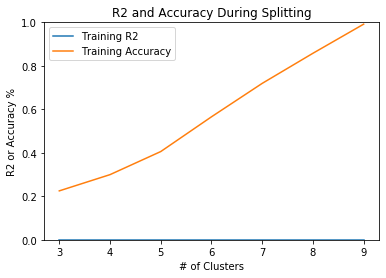

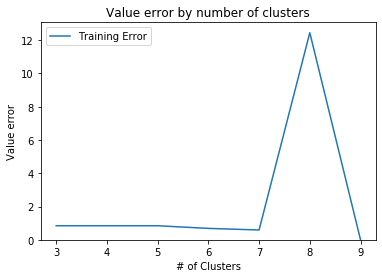

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [5]:
m = MDP_model()
m.fit(df, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
    pfeatures, # int: number of features
    h, # int: time horizon (# of actions we want to optimize)
    max_k, # int: number of iterations
    distance_threshold, # clustering diameter for Agglomerative clustering
    cv, # number for cross validation
    th, # splitting threshold
    classification, # classification method
    clustering,# clustering method from Agglomerative, KMeans, and Birch
    n_clusters, # number of clusters for KMeans
    random_state,
    plot=True,
    optimize=False)

## Visualizing Results

If `plot = True` above, you should see that the final Value error drops to close to 0 when the number of clusters is 9, which is what should be the case for a 3 by 3 maze! Here is another visualization of how the correct clusters should be:

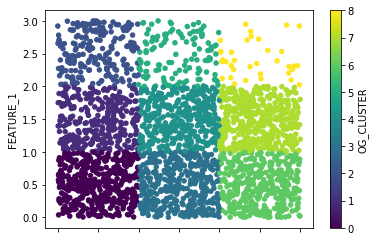

In [6]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', c='OG_CLUSTER')

And here is a visualization of how the algorithm currently views where the clusters are:

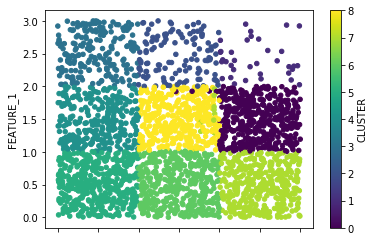

In [7]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', c='CLUSTER')

We can see that the clustering may not be completely perfect, and to quantify this, we can look at both the `training_error` and `purity`. The dataframe created by `training_error` tells us how the error was when we had that many clusters, so the error corresponding to `Clusters = 9` should be the lowest.

In [8]:
m.training_error

,Clusters,Error
0,3,8.459562e-01
1,4,8.459562e-01
2,5,8.459562e-01
3,6,6.857689e-01
4,7,5.895740e-01
5,8,1.245022e+01
6,9,1.365890e-15


The `purity` compares how much of the new clustering was made up of points from the same original cluster. We can see the percentage breakdown here - the higher the percentage, the better! 

In [9]:
purity(m.df_trained)

CLUSTER
0    0.991131
1    1.000000
2    0.991597
3    1.000000
4    1.000000
5    0.997658
6    0.985577
7    0.973615
8    1.000000
Name: Purity, dtype: float64